# **Delta Hedging with SPX Options**

Delta hedging is a risk management strategy used by options traders to reduce or neutralize the risk associated with price movements in the underlying asset. The strategy involves adjusting the position in the underlying asset (such as stocks or futures) to offset changes in the option's delta. Delta measures the sensitivity of the option’s price to changes in the price of the underlying asset. As the option’s delta fluctuates, traders dynamically adjust their position to remain hedged.

In this approach, we will long an SPX option with a specific delta and one-month maturity. Implied volatility will be used to perform dynamic delta hedging throughout the option's life, with adjustments made continuously until the option expires.

*We will use the VIX to represent implied volatility and the one-month risk-free rate as a substitute for the daily risk-free rate.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


# Download OVX data
ovx_data = yf.download('^OVX', start="1999-12-01", end="2024-11-07")
print(ovx_data.head())

# Download VIX data
vix_data = yf.download('^VIX', start="2006-03-01", end="2024-12-20")
print(vix_data.head())

# Download SPX data
spx_ticker = "^GSPC"
spx_data = yf.download(spx_ticker, start="2006-03-01", end="2024-12-20", interval="1d")

[*********************100%***********************]  1 of 1 completed


Price                      Adj Close      Close       High        Low  \
Ticker                          ^OVX       ^OVX       ^OVX       ^OVX   
Date                                                                    
2007-05-10 00:00:00+00:00  27.090000  27.090000  27.090000  27.090000   
2007-05-11 00:00:00+00:00  26.410000  26.410000  26.410000  26.410000   
2007-05-14 00:00:00+00:00  27.230000  27.230000  27.230000  27.230000   
2007-05-15 00:00:00+00:00  27.889999  27.889999  27.889999  27.889999   
2007-05-16 00:00:00+00:00  27.070000  27.070000  27.070000  27.070000   

Price                           Open Volume  
Ticker                          ^OVX   ^OVX  
Date                                         
2007-05-10 00:00:00+00:00  27.090000      0  
2007-05-11 00:00:00+00:00  26.410000      0  
2007-05-14 00:00:00+00:00  27.230000      0  
2007-05-15 00:00:00+00:00  27.889999      0  
2007-05-16 00:00:00+00:00  27.070000      0  


[*********************100%***********************]  1 of 1 completed


Price                     Adj Close  Close   High    Low   Open Volume
Ticker                         ^VIX   ^VIX   ^VIX   ^VIX   ^VIX   ^VIX
Date                                                                  
2006-03-01 00:00:00+00:00     11.54  11.54  12.07  11.52  12.05      0
2006-03-02 00:00:00+00:00     11.72  11.72  11.95  11.56  11.79      0
2006-03-03 00:00:00+00:00     11.96  11.96  12.10  11.36  12.03      0
2006-03-06 00:00:00+00:00     12.74  12.74  12.91  12.22  12.22      0
2006-03-07 00:00:00+00:00     12.66  12.66  13.34  12.64  12.92      0


[*********************100%***********************]  1 of 1 completed


In [ ]:
from google.colab import files
uploaded = files.upload()

file_names = list(uploaded.keys())

expiration_data = pd.read_csv(file_names[0])
expiration_data['Expiration'] = pd.to_datetime(expiration_data['Expiration'], format='%m/%d/%y')

rate_data = pd.read_csv(file_names[1])
rate_data['Date'] = pd.to_datetime(rate_data['Date'], format='%m/%d/%y')  # Adjust format as necessary
rate_data.set_index('Date', inplace=True)
rate_data.rename(columns={'Close': 'Monthly_Rate'}, inplace=True)

Now that we have our data, we need to reformat it so that we can use it efficiently. vix_data and spx_data have multilevel indexes. By taking the second level values and retaining only the "Close" column, we create new dataframes that only include the date and closing price of VIX and SPX. We  reset the index to make 'Date' a regular column and then merge the datasets by date.

In [ ]:
# For VIX data
vix_data.columns = vix_data.columns.get_level_values(1)  # Flatten the multi-level columns
vix_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # Adjust to your expected columns
vix_vol = vix_data[['Close']].copy()  # Extract Close column
vix_vol.index = pd.to_datetime(vix_vol.index).normalize().tz_localize(None)  # Normalize and remove timezone
vix_vol.reset_index(inplace=True)  # Reset the index and add it as a column
vix_vol.rename(columns={'index': 'Date'}, inplace=True)  # Rename 'index' column to 'Date'

# For SPX data
spx_data.columns = spx_data.columns.get_level_values(1)  # Flatten the multi-level columns
spx_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # Adjust to your expected columns
spx_data = spx_data[['Close']].copy()  # Extract Close column
spx_data.index = pd.to_datetime(spx_data.index).normalize().tz_localize(None)  # Normalize and remove timezone
spx_data.reset_index(inplace=True)  # Reset the index and add it as a column
spx_data.rename(columns={'index': 'Date'}, inplace=True)  # Rename 'index' column to 'Date'

backtest_data = pd.merge(spx_data[['Date', 'Close']], vix_vol[['Date', 'Close']], on='Date', suffixes=('_spx', '_vix'))

Then merging our vix and spx data with contract expiration dates and the corresponding monthly risk free rate.

In [ ]:
merged_data = pd.merge_asof(
    backtest_data,
    expiration_data,
    left_on='Date',
    right_on='Expiration',
    direction='forward'
)
merged_data['Monthly_Rate'] = merged_data['Date'].apply(
    lambda x: rate_data.loc[rate_data.index <= x, 'Monthly_Rate'].iloc[-1]
)

In [ ]:
print(merged_data.tail(10))

           Date    Close_spx  Close_vix Expiration  Monthly_Rate
4705 2024-11-07  5947.209961  15.130000 2024-11-22         4.645
4706 2024-11-08  5976.759766  14.660000 2024-11-22         4.645
4707 2024-11-11  5986.689941  14.890000 2024-11-22         4.645
4708 2024-11-12  5960.080078  14.690000 2024-11-22         4.645
4709 2024-11-13  5965.910156  13.770000 2024-11-22         4.645
4710 2024-11-14  5942.279785  13.590000 2024-11-22         4.645
4711 2024-11-15  5853.009766  14.560000 2024-11-22         4.645
4712 2024-11-18  5865.950195  15.350000 2024-11-22         4.645
4713 2024-11-19  5855.290039  15.370000 2024-11-22         4.645
4714 2024-11-20  5860.560059  16.040001 2024-11-22         4.645


We define the Black-Scholes formula as a function:

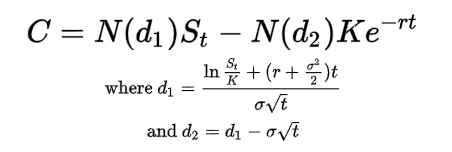

In [ ]:
from scipy.stats import norm
spx_complete = merged_data
spx_complete['Days_to_Maturity'] = (spx_complete['Expiration'] - spx_complete['Date']).dt.days
spx_complete['T'] = spx_complete['Days_to_Maturity'] / 360


def black_scholes(S, K, T, r, sigma):
    # Prevent issues with very small sigma by setting a minimum value for volatility
    sigma = max(sigma, 1e-6)  # Ensure volatility is not too small
    # Prevent issues with very small T (time to maturity)
    T = max(T, 1e-6)  # Ensure time to maturity is not zero or too small
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Option price and delta
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return call_price, delta

# Calculate option prices and deltas using Black-Scholes
spx_complete[['Option_Price', 'Delta']] = spx_complete.apply(
    lambda row: black_scholes(
        row['Close_spx'],  # S = SPX_Close
        row['Close_spx'],  # K = Strike price for ATM options
        row['T'],  # T = Time to maturity in years
        row['Monthly_Rate'],  # r = Risk-free rate
        row['Close_vix']  # sigma = Implied volatility from the VIX
    ),
    axis=1,
    result_type="expand"
)


To simulate daily pricing and sensitivity (delta) tracking for an at-the-money SPX call option over time, this code calculates the theoretical price and delta of a one-month SPX call option each day using the Black-Scholes model. The strike price is reset at the beginning of each month to be at-the-money (equal to the SPX price), reflecting a strategy where a new option is opened monthly at the current SPX level.

In [ ]:
# Hedging and Transaction costs
Q = 100  # Quantity of options
transaction_cost = 0.0005  # Transaction cost (e.g., 0.05%)
spx_complete['Hedging_Position'] = -spx_complete['Delta'] * Q
spx_complete['Transaction_Cost'] = transaction_cost * abs(spx_complete['Hedging_Position']) * spx_complete['Close_spx']
spx_complete['Net_Cash_Flow'] = -spx_complete['Hedging_Position'] * spx_complete['Close_spx'] - spx_complete['Transaction_Cost']

# Recalculate daily option price and delta, adjust hedging positions
spx_complete['Daily_Option_Price'] = 0.0
spx_complete['Daily_Delta'] = 0.0
spx_complete['Interest_Accrued'] = 0.0
spx_complete['Portfolio_Value'] = 0.0

# Daily Repricing and Delta Adjustment
for i in range(1, len(spx_complete)):
    current_row = spx_complete.iloc[i]

    # Recalculate option price and delta
    option_price, delta = black_scholes(
        current_row['Close_spx'],
        current_row['Close_spx'],  # ATM strike price
        current_row['T'],
        current_row['Monthly_Rate'],  # Risk-free rate
        current_row['Close_vix']  # Implied volatility
    )

    spx_complete.at[i, 'Daily_Option_Price'] = option_price
    spx_complete.at[i, 'Daily_Delta'] = delta

    # Adjust hedging position
    spx_complete.at[i, 'Hedging_Position'] = -delta * Q

    # Interest accrual (daily compounding)
    previous_cash_position = spx_complete.at[i-1, 'Net_Cash_Flow']
    spx_complete.at[i, 'Interest_Accrued'] = previous_cash_position * (current_row['Monthly_Rate'] / 365)

    # Update Portfolio Value
    spx_complete.at[i, 'Portfolio_Value'] = (
        spx_complete.at[i, 'Daily_Option_Price'] * Q +
        previous_cash_position +
        spx_complete.at[i, 'Interest_Accrued']
    )

# Calculate Daily PnL
spx_complete['Daily_PnL'] = spx_complete['Portfolio_Value'].diff()

Then calculating our monthly PnL:

In [ ]:
# Ensure the 'Date' column is in datetime format
spx_complete['Date'] = pd.to_datetime(spx_complete['Date'])

# Set 'Date' as the index of the DataFrame
spx_complete.set_index('Date', inplace=True)

# Calculate Monthly PnL by summing daily PnL for each month
monthly_pnl = spx_complete['Daily_PnL'].resample('ME').sum()

# Reset the index to include 'Date' as a column in the monthly data
monthly_pnl = monthly_pnl.reset_index()
monthly_pnl.rename(columns={'Daily_PnL': 'Monthly_PnL'}, inplace=True)
monthly_pnl['Cumulative_PnL'] = monthly_pnl['Monthly_PnL'].cumsum()

In [ ]:
# Drop the last row from the monthly_pnl DataFrame
monthly_pnl = monthly_pnl.drop(monthly_pnl.tail(1).index)

In [ ]:
expiry_dates = spx_complete['Expiration'].unique()
for expiry_date in expiry_dates:
    expiry_row = spx_complete[spx_complete['Expiration'] == expiry_date].copy()

    # Assuming delta at expiry for ATM options is 1 if in the money, 0 if out of the money
    expiry_row.loc[:, 'Daily_Delta'] = 1  # Set delta to 1, assuming the option expires in the money (ITM)

    # Final cash position
    final_position_value = expiry_row['Daily_Option_Price'].iloc[-1] * Q
    final_cash_position = expiry_row['Net_Cash_Flow'].iloc[-1] + final_position_value

    # Calculate Expiry PnL
    expiry_row.loc[:, 'Expiry_PnL'] = final_cash_position - expiry_row['Net_Cash_Flow'].iloc[0]

    # Update spx_complete DataFrame with the expiry data
    spx_complete.loc[spx_complete['Expiration'] == expiry_date, 'Daily_Delta'] = expiry_row['Daily_Delta']
    spx_complete.loc[spx_complete['Expiration'] == expiry_date, 'Expiry_PnL'] = expiry_row['Expiry_PnL']



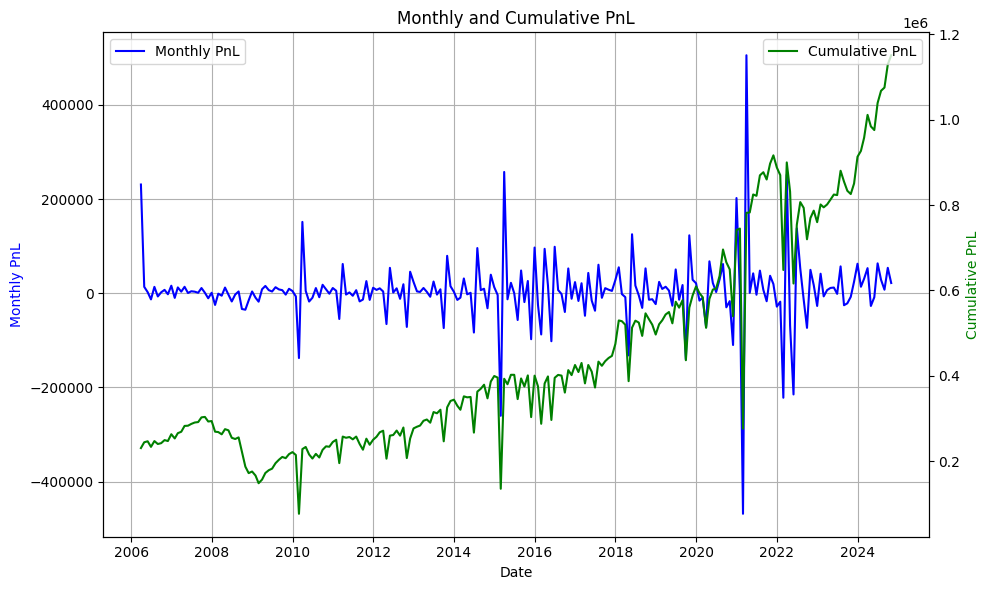

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Monthly PnL on the primary axis
ax1.plot(monthly_pnl['Date'], monthly_pnl['Monthly_PnL'], label='Monthly PnL', color='blue')
ax1.set_title('Monthly and Cumulative PnL')
ax1.set_ylabel('Monthly PnL', color='blue')
ax1.set_xlabel('Date')
ax1.grid(True)
ax1.legend(loc='upper left')

# Create a second y-axis for Cumulative PnL
ax2 = ax1.twinx()  # This shares the same x-axis
ax2.plot(monthly_pnl['Date'], monthly_pnl['Cumulative_PnL'], label='Cumulative PnL', color='green')
ax2.set_ylabel('Cumulative PnL', color='green')
ax2.legend(loc='upper right')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

The spikes in monthly PnL suggest that the delta hedging strategy is highly responsive to market volatility, as it involves adjusting the underlying asset position frequently in response to changing deltas. This is characteristic of delta hedging, where a trader adjusts positions continuously to mitigate the risk of the option's price changes due to movements in the underlying asset.

Despite the sharp fluctuations in monthly returns, the cumulative PnL increases steadily, reflecting the long-term effectiveness of the delta hedging strategy. Over time, the strategy protects the portfolio from large losses and generates positive returns, highlighting its ability to mitigate risk.

The high volatility seen in the monthly PnL is a trade-off between short-term risk management (through frequent adjustments) and long-term stability (capturing the overall trend of the asset price). While delta hedging is meant to reduce risk, its nature leads to periodic high rewards or losses depending on market movements.


The delta hedging strategy proves to be a valuable tool for managing risk and maintaining a steady performance over time, despite the inherent short-term volatility.
